In [1]:
import tensorflow as tf
from keras.layers import ZeroPadding2D,Dense
import math
import numpy as np
import os
from keras import backend as K
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [3]:
class Siamese(object):
    def __init__(self,size_x,size_y):
        self.network = ""
        self.feature_size = size_x
        self.lable_size = size_y
        self.learning_rate = 0.001
        self.loss = 0
        self.train_op = ""
        self.x1 = tf.placeholder("float",name='x1',shape = [None, self.feature_size])
        self.x2 = tf.placeholder("float", name='x2',shape = [None, self.feature_size])
        self.y1 = tf.placeholder("int32", name='y1',shape = [None, self.lable_size])
        self.y2 = tf.placeholder("int32",name='y2', shape = [None, self.lable_size])
        self.output1 = ""
        self.output2 = ""
        self.condition = ""
        self.case_loss = ""
        self.test = ""
        self.sess = tf.Session()
        self.build_network()
    def build_network(self):
        num_hidden = 32
        c = 1
        num_classes = 10
        weights = {
            'w1': tf.Variable(tf.random_normal([self.feature_size, num_hidden])),
            'w2': tf.Variable(tf.random_normal([num_hidden, num_classes]))
        }
        biases = {
            'b1': tf.Variable(tf.random_normal([num_hidden])),
            'b2': tf.Variable(tf.random_normal([num_classes]))
        }
        output1 = tf.nn.relu(tf.matmul(self.x1,weights['w1']) + biases['b1'])
        output1 = tf.matmul(output1,weights['w2']) + biases['b2']
        output2 = tf.nn.relu(tf.matmul(self.x2,weights['w1']) + biases['b1'])
        output2 = tf.matmul(output2,weights['w2']) + biases['b2']
        self.output1 = output1
        self.output2 = output2
        self.condition = tf.placeholder(tf.bool, shape=[], name="condition")
        def if_True():
            return tf.losses.mean_squared_error(output1, output2)
        def if_False():
            return tf.maximum(c - tf.losses.mean_squared_error(output1, output2),0)
        self.case_loss = tf.cond(self.condition, if_True , if_False)
        self.loss = self.loss + self.case_loss
        optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        self.train_op = optimizer.minimize(self.loss)
    def pair(self):
        pair_x = []
        pair_y = []
        for i,j in zip(self.train_X,self.train_Y):
            temp_x = []
            temp_y = []
            for x,y in zip(self.train_X,self.train_Y):
                temp_x.append([i,x])
                temp_y.append([j,y])
            pair_x.append(temp_x)
            pair_y.append(temp_y)
        return pair_x,pair_y
    def train(self,training_steps):
        # Initialize the variables (i.e. assign their default value)
        init = tf.global_variables_initializer()
        batch_size = 32
        display_step = 100
        saver = tf.train.Saver()
    # Start training

        # Run the initializer
        self.sess.run(init)

        for step in range(1, training_steps+1):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop)
            for i,j in zip(batch_x,batch_y):
                for x,y in zip(batch_x,batch_y):
                    i = i.reshape([1,self.feature_size])
                    j= j.reshape([1,self.lable_size])
                    x = x.reshape([1,self.feature_size])
                    y = y.reshape([1,self.lable_size])
                    index1, = np.where(j[0] == 1)
                    index2, = np.where(y[0] == 1)
                    #print(index1,index2)
                    if(index1[0] == index2[0]):
                        cond = True
                    else:
                        cond = False
                    #print(cond)
                    _temp = self.sess.run([self.train_op,self.loss], feed_dict={self.x1 : i, self.x2 : x,self.y1 : j, self.y2 : y,self.condition:cond})
                    #print(temp)
            if 1:
                # Calculate batch loss and accuracy
                total_loss = 0
                for i,j in zip(batch_x,batch_y):
                    for x,y in zip(batch_x,batch_y):
                        i = i.reshape([1,self.feature_size])
                        j= j.reshape([1,self.lable_size])
                        x = x.reshape([1,self.feature_size])
                        y = y.reshape([1,self.lable_size])
                        index1, = np.where(j[0] == 1)
                        index2, = np.where(y[0] == 1)
                        #print(index1,index2)
                        if(index1[0] == index2[0]):
                            cond = True
                        else:
                            cond = False
                        loss = self.sess.run([self.loss],feed_dict={self.x1 : i, self.x2 : x,self.y1 : j, self.y2 : y,self.condition:cond})
                        total_loss += loss[0]
                print("Step " + str(step) + ", Minibatch Loss= " + \
                      "{:.4f}".format(total_loss))

        print("Optimization Finished!")
        save_path = saver.save(self.sess, "/tmp/model/siamese.ckpt")
    def predict(self,a,b):
        #tf.reset_default_graph()
        a = a.reshape([1,self.feature_size])
        b = b.reshape([1,self.feature_size])
        temp1,temp2 = self.sess.run([self.output1,self.output2], feed_dict={self.x1 : a, self.x2 : b})
        return np.sum(abs(temp1-temp2))

In [4]:
batch_x, batch_y = mnist.train.next_batch(32)

In [5]:
siamese_network = Siamese(batch_x.shape[1], batch_y.shape[1])

In [6]:
sess = siamese_network.train(50)

Step 1, Minibatch Loss= 18866.6350
Step 2, Minibatch Loss= 8092.9728
Step 3, Minibatch Loss= 5481.6709
Step 4, Minibatch Loss= 3169.3626
Step 5, Minibatch Loss= 1490.3421
Step 6, Minibatch Loss= 522.5423
Step 7, Minibatch Loss= 643.8880
Step 8, Minibatch Loss= 302.3325
Step 9, Minibatch Loss= 399.2154
Step 10, Minibatch Loss= 403.4974
Step 11, Minibatch Loss= 496.4254
Step 12, Minibatch Loss= 430.0296
Step 13, Minibatch Loss= 528.5333
Step 14, Minibatch Loss= 475.8597
Step 15, Minibatch Loss= 563.3101
Step 16, Minibatch Loss= 469.4447
Step 17, Minibatch Loss= 506.3568
Step 18, Minibatch Loss= 515.8438
Step 19, Minibatch Loss= 640.2323
Step 20, Minibatch Loss= 368.7523
Step 21, Minibatch Loss= 280.5113
Step 22, Minibatch Loss= 308.2188
Step 23, Minibatch Loss= 298.2682
Step 24, Minibatch Loss= 207.0968
Step 25, Minibatch Loss= 340.8509
Step 26, Minibatch Loss= 335.7223
Step 27, Minibatch Loss= 243.3783
Step 28, Minibatch Loss= 198.8292
Step 29, Minibatch Loss= 211.4757
Step 30, Minibatc

In [7]:
class SpectralNet(object):
    def __init__(self,mnist,siamese_network):
        self.network = ""
        self.learning_rate = 0.001
        self.loss = 0
        self.train_op = ""
        self.batch_size = 4
        batch_x, batch_y = mnist.train.next_batch(self.batch_size)
        self.feature_size = batch_x[0].shape[0]
        self.x = tf.placeholder("float",name='x',shape = [None, self.feature_size])
        batch_x, batch_y = mnist.train.next_batch(32)
        self.siamese_network = siamese_network
        self.build_network()
        self.sess = tf.Session()
    def build_network(self):
        num_hidden = 32
        num_classes = 10
        weights = {
            'w1': tf.Variable(tf.random_normal([self.feature_size, num_hidden])),
            'w2': tf.Variable(tf.random_normal([num_hidden, num_classes])),
            'orth': tf.Variable(tf.random_normal([num_classes, num_classes]),name='orth')
        }
        biases = {
            'b1': tf.Variable(tf.random_normal([num_hidden])),
            'b2': tf.Variable(tf.random_normal([num_classes]))
        }
        output = tf.nn.relu(tf.matmul(self.x,weights['w1']) + biases['b1'])
        output = tf.nn.softmax(tf.matmul(output,weights['w2']) + biases['b2'])
        #weights['orth'] = self.orthonorm_op(output)
        self.before_orth = output
        self.W = tf.placeholder("float",name='W',shape = [self.batch_size,self.batch_size])
        output = tf.matmul(output,self.orthonorm_op(output))
        self.embed_y = output
        for i in range(self.batch_size):
            for j in range(self.batch_size):
                self.loss += tf.reduce_sum((tf.abs(output[i]-output[j])))*self.W[i][j]
        optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        self.train_op = optimizer.minimize(self.loss)
    def aff_matrix(self,train_x):
        w = []
        for i in train_x:
            temp_w = []
            for j in train_x:
                temp = self.siamese_network.predict(i,j)
                temp_w.append(temp)
            w.append(temp_w)
        return w
    def orthonorm_op(self,x, epsilon=1e-7):
        x_2 = K.dot(K.transpose(x), x)
        x_2 += K.eye(K.int_shape(x)[1])*epsilon
        print(x_2)
        L = tf.cholesky(x_2)
        ortho_weights = tf.transpose(tf.matrix_inverse(L)) * tf.sqrt(tf.cast(tf.shape(x)[0], dtype=K.floatx()))
        return ortho_weights
    def train(self,training_steps):
        init = tf.global_variables_initializer()
        saver = tf.train.Saver()
        
        # Start training
        # Run the initializer
        self.sess.run(init)
        for step in range(1, training_steps+1):
            batch_x, batch_y = mnist.train.next_batch(self.batch_size)
            feed_dict={
                self.x : batch_x,
                self.W : self.aff_matrix(batch_x)
            }
            _,loss = self.sess.run([self.train_op,self.loss],feed_dict =feed_dict)
            print("Step " + str(step) + ", Minibatch Loss= " + \
                      "{:.4f}".format(loss))
    def predict(self,test_x): 
        return self.sess.run([self.embed_y], feed_dict={self.x : test_x})

In [8]:
S_network = SpectralNet(mnist,siamese_network)

Tensor("add_7:0", shape=(10, 10), dtype=float32)


In [9]:
S_network.train(50)

Step 1, Minibatch Loss= 213.3877
Step 2, Minibatch Loss= 500.4944
Step 3, Minibatch Loss= 282.8593
Step 4, Minibatch Loss= 301.9021
Step 5, Minibatch Loss= 765.2753
Step 6, Minibatch Loss= 487.3140
Step 7, Minibatch Loss= 178.0887
Step 8, Minibatch Loss= 180.0636
Step 9, Minibatch Loss= 359.4991
Step 10, Minibatch Loss= 605.0786
Step 11, Minibatch Loss= 746.5096
Step 12, Minibatch Loss= 637.6595
Step 13, Minibatch Loss= 664.6064
Step 14, Minibatch Loss= 801.6641
Step 15, Minibatch Loss= 632.7047
Step 16, Minibatch Loss= 697.9207
Step 17, Minibatch Loss= 382.2742
Step 18, Minibatch Loss= 462.5614
Step 19, Minibatch Loss= 232.5236
Step 20, Minibatch Loss= 580.8422
Step 21, Minibatch Loss= 462.5860
Step 22, Minibatch Loss= 554.9055
Step 23, Minibatch Loss= 403.2976
Step 24, Minibatch Loss= 441.2100
Step 25, Minibatch Loss= 592.6334
Step 26, Minibatch Loss= 386.3597
Step 27, Minibatch Loss= 478.1457
Step 28, Minibatch Loss= 456.5338
Step 29, Minibatch Loss= 563.1348
Step 30, Minibatch Loss

In [10]:
def get_label(train_x):
    kmeans = KMeans(n_clusters=10, random_state=0).fit(train_x)
    return kmeans.predict(train_x)     

In [11]:
batch_x, batch_y = mnist.train.next_batch(512)
pca_a = PCA(n_components=2, copy=True, whiten=False)
pca_b = PCA(n_components=2, copy=True, whiten=False)
a = S_network.predict(batch_x)[0]
b = batch_x
pca_a.fit(a)
pca_b.fit(b)
a = pca_a.transform(a)
b = pca_b.transform(b)
label_a = get_label(a)
label_b = get_label(b)


In [12]:
print()

In [13]:
plt.scatter(a[:,0],a[:,1],s=10, c=label_a, alpha=.5)

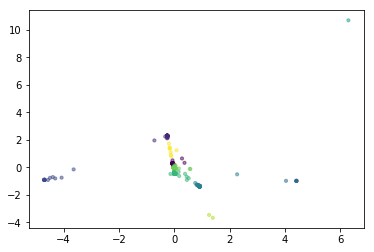

In [14]:
plt.show()

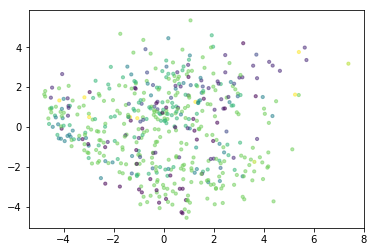

In [15]:
plt.scatter(b[:,0],b[:,1],s=10, c=label_a, alpha=.5)
plt.show()